In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit


In [5]:
generation_NY = pd.read_parquet('../data/ML_Data/NY',  engine='pyarrow')
generation_Florida= pd.read_parquet('../data/ML_Data/FL',  engine='pyarrow')
generation_California = pd.read_parquet('../data/ML_Data/CA', engine='pyarrow')
generation_Texas =pd.read_parquet('../data/ML_Data/TX', engine='pyarrow')

In [6]:
generation_Texas.head()

,respondent,value,year,month,days,hour,quarter,dayofyear,temp,feelslike,...,Holiday_New Year's Eve,Holiday_Presidents' Day,Holiday_St. Patrick's Day,Holiday_Super Tuesday,Holiday_Tax Day,Holiday_Thanksgiving Day,Holiday_Valentine's Day,Holiday_Veterans Day,Holiday_Veterans Day (substitute),Energy_30D_AVG
period,,,,,,,,,,,,,,,,,,,,,
2015-07-31 06:00:00,"Electric Reliability Council of Texas, Inc.",46778.0,2015,7,6,6,3,212,72.0,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49637.091667
2015-07-31 07:00:00,"Electric Reliability Council of Texas, Inc.",44058.0,2015,7,6,7,3,212,71.8,71.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49649.506944
2015-07-31 08:00:00,"Electric Reliability Council of Texas, Inc.",41826.0,2015,7,6,8,3,212,74.8,74.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49660.879167
2015-07-31 09:00:00,"Electric Reliability Council of Texas, Inc.",40449.0,2015,7,6,9,3,212,78.4,78.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49671.505556
2015-07-31 10:00:00,"Electric Reliability Council of Texas, Inc.",39910.0,2015,7,6,10,3,212,80.4,81.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49681.373611


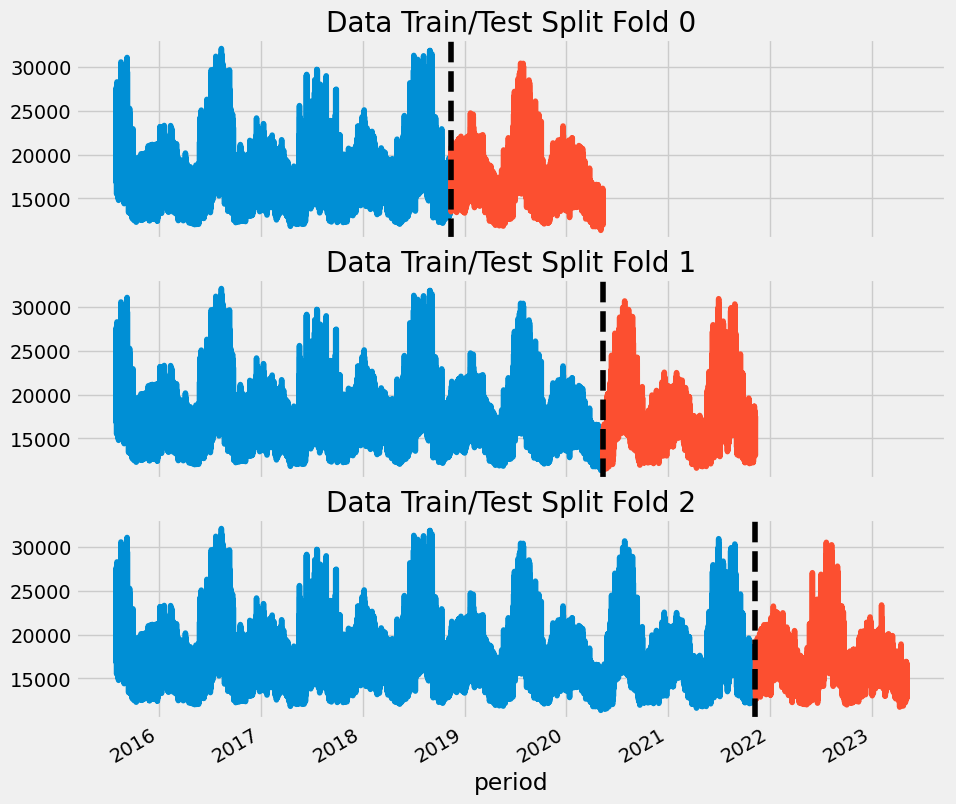

In [7]:
fig, axs = plt.subplots(3,1, figsize=(10,10), sharex=True)
tss = TimeSeriesSplit(n_splits=3, test_size=24*547, gap=24)
fold = 0
for train_idx, val_idx in tss.split(generation_NY):
    train = generation_NY.iloc[train_idx]
    test = generation_NY.iloc[val_idx]
    train['value'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['value'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [8]:
TARGET = 'value'
FEATURES = generation_NY.columns[2:]

In [9]:
def xgb_train(df):
    tss = TimeSeriesSplit(n_splits=3, test_size=24*547, gap=24)
    df = df.sort_index()
    fold = 0
    preds = []
    scores_rmse = []
    scores_mae = []
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        X_train = train[FEATURES]
        y_train = train[TARGET]
        X_test = test[FEATURES]
        y_test = test[TARGET]
        reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                                    n_estimators=8000,
                                    early_stopping_rounds=100,
                                    max_depth=10,
                                    learning_rate=0.007,
                                    subsample = 0.9,
                                    reg_lambda = 1,
                                    min_child_weight =1,
                                    colsample_bytree = 0.8,
                                    colsample_bylevel = 0.8,
                                    colsample_bynode = 0.7,
                                    random_state =0,
                                    eval_metric =['rmse', 'mae'])
        reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            )
        y_pred = reg.predict(X_test)
        preds.append(y_pred)
        score_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        scores_rmse.append(score_rmse)
        scores_mae.append(mean_absolute_error(y_test,y_pred))
    print(f'Score across folds {np.mean(scores_rmse):0.4f}')
    print(f'Fold scores:{scores_rmse}')
    print(f'Score across folds {np.mean(scores_mae):0.4f}')
    print(f'Fold scores:{scores_mae}')

    return reg, X_test, test

In [10]:
def create_graphs(df, X_test,test, week=None):
    if week is None:
        week = ['12-20-2022', '12-27-2022']
    test['prediction'] = reg.predict(X_test)
    df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
    ax = df[['value']].plot(figsize=(15, 6))
    df['prediction'].plot(ax=ax, style='.')
    plt.legend(['Actual', 'Predicted'],loc='upper right')
    ax.set_title('Actual VS. Predicted')
    plt.show()


    ax = df.loc[(df.index > week[0]) & (df.index < week[1])]['value'] \
    .plot(figsize=(15, 6), title='Week Of Data')
    df.loc[(df.index > week[0]) & (df.index < week[1])]['prediction'] \
        .plot()
    plt.legend(['Actual','Predicted'],loc='upper right')
    plt.show()

In [11]:
def create_importance(model):
    fig, ax = plt.subplots(figsize=(10,10))
    xgb.plot_importance(model,importance_type='weight', ax=ax, show_values=False, max_num_features=30)

In [12]:
def run_model(df, week_list=None):
    if week_list == None:
        week = ['03-01-2023', '03-07-2023']
    else:
        week = week_list
    reg, X_test, test =xgb_train(df)
    create_graphs(df,X_test=X_test, test=test, week=week)
    create_importance(reg)

In [13]:
model_CA = run_model(generation_California)

[0]	validation_0-rmse:26725.91688	validation_0-mae:26243.45878	validation_1-rmse:24070.59226	validation_1-mae:23670.23774
[1]	validation_0-rmse:26540.87862	validation_0-mae:26060.03032	validation_1-rmse:23895.31837	validation_1-mae:23495.30717
[2]	validation_0-rmse:26356.75505	validation_0-mae:25877.99171	validation_1-rmse:23722.01052	validation_1-mae:23322.81695
[3]	validation_0-rmse:26174.05706	validation_0-mae:25697.19613	validation_1-rmse:23550.38520	validation_1-mae:23152.01236
[4]	validation_0-rmse:25992.64769	validation_0-mae:25517.63593	validation_1-rmse:23376.10954	validation_1-mae:22978.68215
[5]	validation_0-rmse:25812.37770	validation_0-mae:25339.44005	validation_1-rmse:23204.73532	validation_1-mae:22808.36407
[6]	validation_0-rmse:25633.38791	validation_0-mae:25162.43940	validation_1-rmse:23035.35438	validation_1-mae:22639.98901
[7]	validation_0-rmse:25455.63581	validation_0-mae:24986.70064	validation_1-rmse:22864.50653	validation_1-mae:22470.17222
[8]	validation_0-rmse:25

KeyboardInterrupt: 

In [ ]:
model_NY = run_model(generation_NY)

In [ ]:
model_TX = run_model(generation_Texas)

In [ ]:
model_FL = run_model(generation_Florida)

In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2022-09-07    6989.057699
2022-09-06    6079.327393
2022-09-08    5241.943848
2022-09-09    4885.357666
2022-08-17    4391.198812
2022-08-18    3402.161214
2022-04-08    3357.935872
2022-09-05    3264.406982
2022-06-22    3166.530843
2022-07-05    3103.454834
Name: error, dtype: float64